### Description
This Notebook compares our package to the SOTA package for audio classification: [pyAudioAnalysis](https://github.com/tyiannak/pyAudioAnalysis) with 6k GitHub stars.
This is NOT an AutoML package as it requires the user to make some choices like which base model to use. Despite that this is the best comparison we could find as there aren't audio ML packages let alone AutoML audio packages.

### Download data
For this part you will need to have kaggle installed. `pip install kaggle`.
Alternativaly you could download the dataset from `https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist` and manually extract it into `data/audio-mnist`

In [1]:
import os
import subprocess

dataset_path = "data/audio-mnist"

if not os.path.exists(dataset_path):
    print("Dataset not found. Downloading...")
    os.makedirs(dataset_path, exist_ok=True)
    subprocess.run(["kaggle", "datasets", "download", "-d", "sripaadsrinivasan/audio-mnist", "-p", dataset_path, "--unzip"])
    print("Download complete.")
else:
    print("Dataset already exists.")

Dataset already exists.


### Data format
We first have to create a dataframe which stores all the data (file paths and labels)

In [3]:
import pandas as pd
numbers_path = os.path.join(dataset_path, "data")
paths = []
labels = []
for speaker in os.listdir(numbers_path):
    folder_path = os.path.join(numbers_path, speaker)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        if not filename.endswith(".wav"):
            continue
        paths.append(os.path.join(folder_path, filename))
        labels.append(filename[0])
df = pd.DataFrame({"file_path": paths, "label": labels})
df = df[df["file_path"] != "data/gtzan-dataset-music-genre-classification\Data/genres_original\jazz\jazz.00054.wav"] # remove corrupted file
df.sample(5)

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
C:\Users\kdens\AppData\Local\Temp\ipykernel_21364\1337877002.py:14: SyntaxWarning: invalid escape sequence '\D'
  df = df[df["file_path"] != "data/gtzan-dataset-music-genre-classification\Data/genres_original\jazz\jazz.00054.wav"] # remove corrupted file


,file_path,label
27029,data/audio-mnist\data\55\0_55_35.wav,0
15723,data/audio-mnist\data\32\4_32_3.wav,4
25826,data/audio-mnist\data\52\6_52_32.wav,6
19936,data/audio-mnist\data\40\8_40_41.wav,8
562,data/audio-mnist\data\02\1_02_2.wav,1


In [4]:
from sklearn.model_selection import train_test_split
df = df.sample(n=1000, random_state=42)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
    
def assess_quality(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot()
    plt.xticks(rotation=90)
    plt.show()

### pyAudioAnalysis

In [6]:
import os
import pandas as pd
import shutil

base_dir = "data/pyAudioAnalysis"
label_dirs = set()

if not os.path.exists(base_dir):
    os.makedirs(base_dir)

    for _, row in df_train.iterrows():
        label_dir = os.path.join(base_dir, str(row["label"]))
        os.makedirs(label_dir, exist_ok=True)
        label_dirs.add(label_dir)
        shutil.copy(row["file_path"], label_dir)
label_dirs = list(label_dirs)

In [ ]:
from pyAudioAnalysis import audioTrainTest as aT
aT.extract_features_and_train(label_dirs, 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm", "svmSMtemp", False) # using settings from the pyAudioAnalysis documentation

c:\Projects\AutoAudio\test\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Analyzing file 1 of 71: data/pyAudioAnalysis\2\2_02_30.wav
Analyzing file 2 of 71: data/pyAudioAnalysis\2\2_03_29.wav
Analyzing file 3 of 71: data/pyAudioAnalysis\2\2_03_43.wav
Analyzing file 4 of 71: data/pyAudioAnalysis\2\2_04_18.wav
Analyzing file 5 of 71: data/pyAudioAnalysis\2\2_04_23.wav
Analyzing file 6 of 71: data/pyAudioAnalysis\2\2_05_19.wav
Analyzing file 7 of 71: data/pyAudioAnalysis\2\2_06_7.wav
Analyzing file 8 of 71: data/pyAudioAnalysis\2\2_07_13.wav
Analyzing file 9 of 71: data/pyAudioAnalysis\2\2_07_16.wav
Analyzing file 10 of 71: data/pyAudioAnalysis\2\2_08_48.wav
Analyzing file 11 of 71: data/pyAudioAnalysis\2\2_09_48.wav
Analyzing file 12 of 71: data/pyAudioAnalysis\2\2_11_0.wav
Analyzing file 13 of 71: data/pyAudioAnalysis\2\2_11_8.wav
Analyzing file 14 of 71: data/pyAudioAnalysis\2\2_12_7.wav
Analyzing file 15 of 71: data/pyAudioAnalysis\2\2_13_19.wav
Analyzing file 16 of 71: data/pyAudioAnalysis\2\2_17_28.wav
Analyzing file 17 of 71: data/pyAudioAnalysis\2\2_19_

In [8]:
predictions = []
for file_path in df_test["file_path"]:
    (idx, probs, labels) = aT.file_classification(file_path, "svmSMtemp","svm")
    pred = labels[np.argmax(probs)]
    predictions.append(pred)

Model Accuracy: 0.84


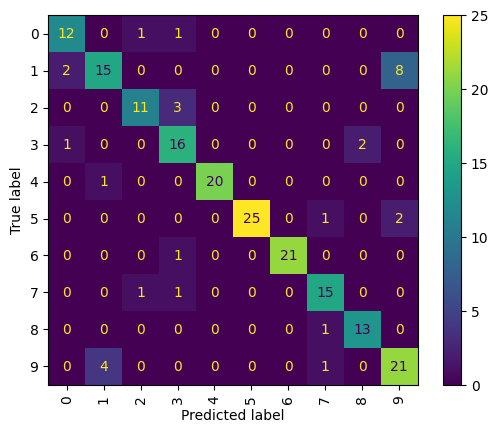

In [9]:
assess_quality(df_test["label"], predictions)

### AutoAudio

In [10]:
from auto_audio.auto_audio_model import AutoAudioModel
model = AutoAudioModel()
model.fit(df_train, time_limit=600)

c:\Projects\AutoAudio\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing audio files.
Finished preprocessing files.
Cuda not available. Not training transformer model.
Training SVM
SVM achieved 56.875% accuracy.
Training KNN
KNN achieved 65.625% accuracy.
Training Gradient Boosting
Gradient Boosting achieved 90.625% accuracy.
Finished training.
Best model is: Gradient Boosting


Model Accuracy: 0.82


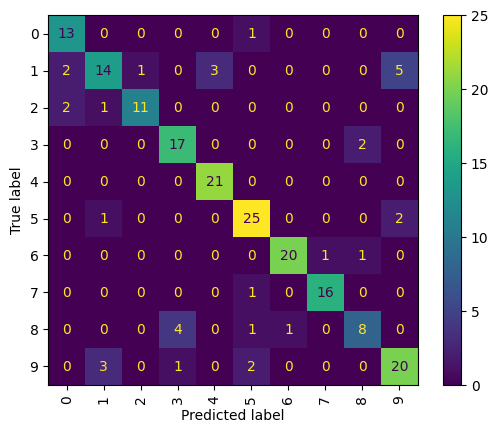

In [11]:
y_test = df_test["label"]
y_pred = model.predict(df_test)
assess_quality(y_test, y_pred)

# Conclusions
pyAudioAnalysis trains for longer but offers a better accuracy than our solution (although not by much). This is to be expected as its a popular and well established project - not a student project. Despite that we believe that our model does some things better:
- Our model offers a time limit parameter
- Our model offers a random_state
- Our model has a nicer interface. This one is subjective but having to positions the files in specific directories for pyAudioAnalysis is not ideal as it requires a little extra work.
- Our model trains multiple different models and chooses the best one all on its own while pyAudioAnalysis uses a more classical non AutoML approach of having to specify the model.

Of course there are plenty of things pyAudioAnalysis does much better than our model. Most important of all it offers a lot of features not offered by our model like visualization. It also offers a lot of different base models while our package only supports four.